<a href="https://colab.research.google.com/github/jyothi-surya/Book_store/blob/main/Stock_Price_Prediction(mini_pro).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import yfinance as yf
import pandas as pd

import numpy as np
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import LSTM,Dense,Dropout

import xgboost as xgb


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [5]:
import yfinance as yf
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1. Define tickers and download (group_by='ticker' makes the returned structure easier to split)
companies = [
    'TSLA', 'NIO', 'RIVN', 'LI', 'LCID',
    'BYDDF', 'XPEV',
    'GM', 'F', 'VWAGY', 'HYMTF',
    'STLA', 'TM', 'GELYF'
]

stock_raw = yf.download(companies, start='2022-01-01', end='2025-03-01', group_by='ticker', auto_adjust=False)

# 2. Convert the grouped dataframe into a tidy long-form dataframe
frames = []
for ticker in companies:
    # Some tickers may not be present in the returned object (e.g., if ticker download failed) -> guard
    if ticker in stock_raw.columns.levels[0]:
        df = stock_raw[ticker].copy()
        df = df.reset_index()                       # Date becomes a column
        df['Company'] = ticker
        frames.append(df)
    else:
        # If a ticker is missing, create an empty placeholder (optional)
        print(f"Warning: {ticker} not found in downloaded data")

# Concatenate all ticker DataFrames
stock_data = pd.concat(frames, ignore_index=True)

# Keep only the columns you want and reorder
stock_data = stock_data[['Date', 'Company', 'Close', 'High', 'Low', 'Open', 'Volume']]

# Convert Date to datetime (safe)
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

# Optional: show column names to verify
print(stock_data.columns)

# 3. Select single stock for modelling (TSLA) and set Date index
data = stock_data.loc[stock_data['Company'] == 'TSLA', ['Date', 'Close']].copy()
data.set_index('Date', inplace=True)

# 4. Scale data for LSTM - use a new column to avoid SettingWithCopyWarning
scaler = MinMaxScaler(feature_range=(0, 1))
data['Close_scaled'] = scaler.fit_transform(data[['Close']])

# If you want to replace the original 'Close' column instead:
# data['Close'] = scaler.fit_transform(data[['Close']])

# Show head
print(data.head())


[**********************86%****************       ]  12 of 14 completedERROR:yfinance:HTTP Error 404: {"quoteSummary":{"result":null,"error":{"code":"Not Found","description":"Quote not found for symbol: HYMTF"}}}
[*********************100%***********************]  14 of 14 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['HYMTF']: YFTzMissingError('possibly delisted; no timezone found')


Index(['Date', 'Company', 'Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price')
Price            Close  Close_scaled
Date                                
2022-01-03  399.926666      0.784987
2022-01-04  383.196655      0.739985
2022-01-05  362.706665      0.684868
2022-01-06  354.899994      0.663869
2022-01-07  342.320007      0.630030


In [6]:
# Converting Time series to Supervised learning format.
def time_sequence(data,time_steps = 60):
  X,y = [],[]
  for i in range(len(data) - time_steps):
    X.append(data[i:(i + time_steps)])
    y.append(data[i + time_steps])
  return np.array(X), np.array(y)

time_steps = 60
X,y = time_sequence(data['Close'].values,time_steps)

# Split data into training and testing
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [7]:
# Tarining LSTM model
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 50337.4062 - val_loss: 95457.3594
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 47114.5195 - val_loss: 88910.2031
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 42803.5273 - val_loss: 81747.1250
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 36532.7383 - val_loss: 74246.1250
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 32335.5117 - val_loss: 66783.4062
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 27447.8789 - val_loss: 59381.0195
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 21292.4102 - val_loss: 52155.8086
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 17562.8496 - val_loss: 45244.0273
Epoch 9/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 14278.9658 - val_loss: 38934.8398
Epoch 10/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 10323.9912 - val_loss: 33391.1719
Epoch 11/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 8650.4580 - val_loss

In [8]:
    #Extract LSTM Features
    lstm_train_features = model.predict(X_train)
    lstm_test_features = model.predict(X_test)

    # Prepare Data for XGBoost
    X_train_xgb = np.hstack((lstm_train_features, X_train.reshape(X_train.shape[0], -1)))
    X_test_xgb = np.hstack((lstm_test_features, X_test.reshape(X_test.shape[0], -1)))


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [9]:
# Training The XGBoost Model

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100)
xgb_model.fit(X_train_xgb, y_train)

# Make Predictions
lstm_predictions = model.predict(X_test)
xgb_predictions = xgb_model.predict(X_test_xgb)

# Combine predictions using weighted average
final_predictions = (0.6 * lstm_predictions.flatten()) + (0.4 * xgb_predictions.flatten())

# Rescale predictions
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
final_predictions_rescaled = scaler.inverse_transform(final_predictions.reshape(-1, 1))


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step



**Model Performance Metrics**
 Model Accuracy: 81.68%
Mean Absolute Error (MAE): 25230.29
Mean Squared Error (MSE): 1199194820.37
Root Mean Squared Error (RMSE): 34629.39
R² Score: -0.2906


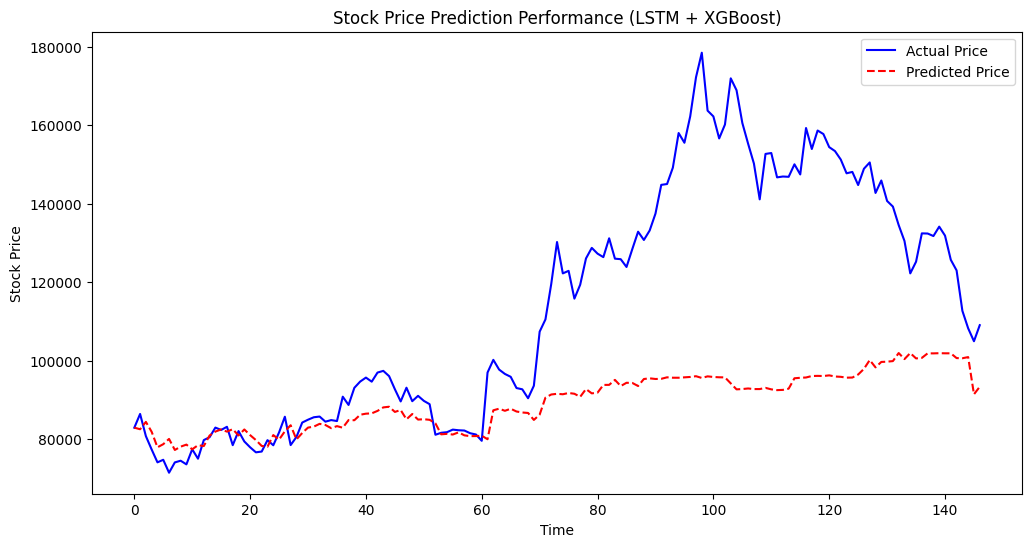

In [10]:
#7. Evaluating The Performance
# Compute Performance Metrics
mape = np.mean(np.abs((y_test_rescaled - final_predictions_rescaled) / y_test_rescaled)) * 100
mae = mean_absolute_error(y_test_rescaled, final_predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, final_predictions_rescaled)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_rescaled, final_predictions_rescaled)

# Approximate Model Accuracy
accuracy = 100 - mape

# Print Performance Metrics
print("\n**Model Performance Metrics**")
print(f" Model Accuracy: {accuracy:.2f}%")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# Plot Predictions vs Actual Prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual Price", color='blue')
plt.plot(final_predictions_rescaled, label="Predicted Price", linestyle='dashed', color='red')
plt.legend()
plt.xlabel("Time")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction Performance (LSTM + XGBoost)")
plt.show()
